In [64]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

In [65]:
mu_labels = []
for nums in range(101):
    if nums == 0:
        pass
    else:
        mu_labels.append("Mu" + str(nums))

In [66]:
mu_cn = pd.read_csv('../examples/mu_cn100.csv')
mu = mu_cn.drop(['CN', 'Num Te', 'Num Cu'], axis=1)
systems = pd.read_csv('../examples/sys100.csv')
weights = pd.read_csv('../examples/weights100.csv')
system_true = systems.iloc[99].dropna()
mu_true = mu.iloc[99].dropna()
weights_true = weights.iloc[99].dropna()
df = pd.read_excel('../examples/XANES_ML_Data.xlsx')
ref_data = df[df['System'].isin(system_true)]

In [67]:
sys_wgt = pd.DataFrame()
sys_wgt['System'] = system_true
sys_wgt['Weights'] = weights_true.values
syswgt = sys_wgt.reset_index()

In [68]:
merged = pd.merge(ref_data, sys_wgt, on=['System'])
mu_data = ref_data[mu_labels]

In [69]:
# coeff_a = merged.loc[0, 'Weights']
# coeff_b = merged.loc[1, 'Weights']
# coeff_c = merged.loc[2, 'Weights']
coeff_a = 0.5
coeff_b = 0.35
coeff_c = 0.15

In [70]:
n = 1000
m = 3

xs = np.linspace(8970, 9050, n)
energies = np.linspace(8970, 9050, 100)

s1 = UnivariateSpline(energies, mu_data.iloc[0,:], s=0)
y1 = s1(xs)
s2 = UnivariateSpline(energies, mu_data.iloc[1,:], s=0)
y2 = s2(xs)
s3 = UnivariateSpline(energies, mu_data.iloc[2,:], s=0)
y3 = s3(xs)
s4 = UnivariateSpline(energies, mu_true, s=0)
y_true = s4(xs)
y4 = y1*coeff_a + y2*coeff_b + y3*coeff_c

In [71]:
# noise = np.random.normal(0,0.005,1000)

X = np.zeros([n, 3])
X[:,0] = y1
X[:,1] = y2
X[:,2] = y3
y = y4
# y = y4+noise

Text(0, 0.5, 'Absorbance')

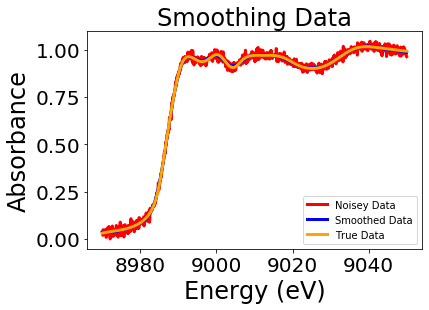

In [76]:
# noise = np.random.normal(0,0.005,1000) # Smoothed well with a 51, 2 savgol_filter
# noise = np.random.normal(0,0.01,1000) # Smoothed well with a 51, 2 savgol filter
noise = np.random.normal(0,0.015,1000)
y_noise = y4+noise
y_smooth = savgol_filter(y_noise, window_length=101, polyorder=2)
y = y_smooth
plt.plot(xs, y_noise, color='red', linewidth=3, label='Noisey Data')
plt.plot(xs, y_smooth, color='blue', linewidth=3, label='Smoothed Data')
plt.plot(xs, y4, color='orange', linewidth=3, label='True Data')
plt.legend()
plt.title('Smoothing Data', fontsize=24)
plt.xlabel('Energy (eV)', fontsize=24)
plt.ylabel('Absorbance', fontsize=24)

In [77]:
random.seed(519)

sequence = [i for i in range(n)]
selection = [0]*n
for i in range(n):
    selection[i] = random.choice(sequence)

iter_ = n

coeffs = [[0.0 for a in range(m)] for b in range(iter_)]
rmse_prop = [0.0]*(iter_)

In [78]:
for k in range(0, iter_):
    n_tr = 1+k

    X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
    for i in range(0, n_tr):
        for j in range(0, m):
            X_train_fl[i][j] = copy.deepcopy(np.float(X[selection[i]][j]))
            
    Prop_train_fl = np.zeros(n_tr)
    for i in range(0, n_tr):
        Prop_train_fl[i] = copy.deepcopy(float(y[selection[i]]))
    
#     lassoreg = Lasso(alpha=0.05)
#     lassoreg.fit(X_train_fl, Prop_train_fl)
#     bayreg = BayesianRidge()
#     bayreg.fit(X_train_fl, Prop_train_fl)

    linreg = LinearRegression()
    linreg.fit(X_train_fl, Prop_train_fl)
    Pred_train = linreg.predict(X_train_fl)
#     Pred_train = lassoreg.predict(X_train_fl)
#     Pred_train = bayreg.predict(X_train_fl)

    for z in range(0,m):
        coeffs[k][z] = linreg.coef_[z]

    X_new = [[0.0 for a in range(m)] for b in range(n)]
    for s in range(0, n):
        for t in range(0, m):
            X_new[s][t] = copy.deepcopy(np.float(X[s][t]))

    Pred_test = linreg.predict(X_new)

    Pred_test_fl = np.zeros(n)
    for i in range(0, n):
        Pred_test_fl[i] = np.float(Pred_test[i])
#     plt.plot(xs, Pred_test_fl, color='blue', linewidth=4, label='Prediction')
#     plt.plot(xs, y_true, color='red', linewidth=4, label='True')
#     plt.title('Test Prediction: %s Data Points' % n_tr, fontsize = 24)
#     plt.xlabel('Energy (eV)', fontsize=24)
#     plt.ylabel('Absorption', fontsize=24)
#     plt.legend()
#     plt.show()
    mse_prop = mean_squared_error(y, Pred_test_fl)
    rmse_prop[k] = np.sqrt(mse_prop)

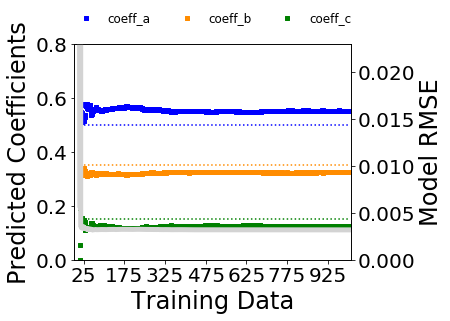

In [79]:
plt.rc('font', family='Arial narrow')

fig, ax1 = plt.subplots(1,1)
plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)

l = len(coeffs)
xx = [0.0]*l
yy1 = [0.0]*l
yy2 = [0.0]*l
yy3 = [0.0]*l

for i in range(0,l):
    xx[i] = i+10
    yy1[i] = coeffs[i][0]
    yy2[i] = coeffs[i][1]
    yy3[i] = coeffs[i][2]

ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')

aa = [0.0]*l
bb = [0.0]*l
cc = [0.0]*l

for i in range(0,l):
    aa[i] = coeff_a
    bb[i] = coeff_b
    cc[i] = coeff_c

ax1.plot(xx, aa, c='blue', ls=':')
ax1.plot(xx, bb, c='darkorange', ls=':')
ax1.plot(xx, cc, c='green', ls=':')

ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
# ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])
ax1.set_ylim([0, 0.8])

ax2 = ax1.twinx()
ax2.plot(xx, rmse_prop, c='lightgrey', ls='-', lw=5)
ax2.set_ylabel('Model RMSE', color='k', fontname='Arial Narrow', size=24)
ax2.set_ylim([0.00,0.023])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.xlim([-10,n_tr+10])
plt.xticks([25, 175, 325, 475, 625, 775, 925])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})

plt.show()

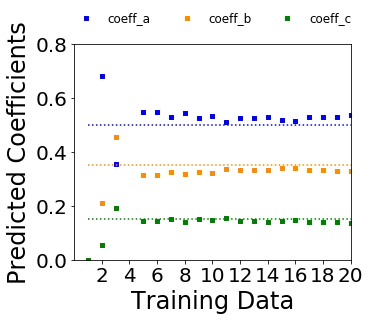

In [80]:
plt.rc('font', family='Arial narrow')

fig, ax1 = plt.subplots(1,1)
plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)

l = len(coeffs)
xx = [0.0]*l
yy1 = [0.0]*l
yy2 = [0.0]*l
yy3 = [0.0]*l

for i in range(0,l):
    xx[i] = i+1
    yy1[i] = coeffs[i][0]
    yy2[i] = coeffs[i][1]
    yy3[i] = coeffs[i][2]

ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')

aa = [0.0]*l
bb = [0.0]*l
cc = [0.0]*l

for i in range(0,l):
    aa[i] = coeff_a
    bb[i] = coeff_b
    cc[i] = coeff_c

ax1.plot(xx, aa, c='blue', ls=':')
ax1.plot(xx, bb, c='darkorange', ls=':')
ax1.plot(xx, cc, c='green', ls=':')

ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
# ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])
ax1.set_ylim([0, 0.8])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
# plt.xlim([-10,n_tr+10])
plt.xticks([2, 4, 6, 8, 10, 12 , 14, 16, 18, 20])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})
plt.xlim([0,20])
plt.show()

In [97]:
print(coeff_a, coeff_b, coeff_c)
print(rmse_prop[3])

0.5 0.35 0.15
0.14948475285386387


In [75]:
first4 = selection[0:4]
print(first4)

[617, 452, 28, 338]


In [76]:
first4energies = xs[first4]
print(first4energies)

[9019.40940941 9006.1961962  8972.24224224 8997.06706707]


Text(0, 0.5, 'Absorption')

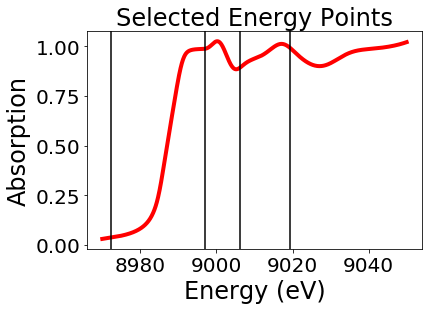

In [69]:
plt.plot(xs, y_true, linewidth=4, color='red')
plt.axvline(x=first4energies[0], color='black')
plt.axvline(x=first4energies[1], color='black')
plt.axvline(x=first4energies[2], color='black')
plt.axvline(x=first4energies[3], color='black')
plt.title("Selected Energy Points", fontsize=24)
plt.xlabel("Energy (eV)", fontsize=24)
plt.ylabel("Absorption", fontsize=24)